<a href="https://colab.research.google.com/github/149segolte/TeachNook/blob/main/Major%20Project/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teachnook Major Project
## **Global climate change analysis**

[Shreyansh Nayak](mailto:nayakshreyansh14@gmail.com) | [Github Link](https://github.com/149segolte/Teachnook)

The objective of this project is to analyse trends in Earth's temperature data and building a model for forecasting.

### Dataset used: [DataHub Global Temperatures](https://datahub.io/core/global-temp)

Average global mean temperature anomalies in degrees Celsius relative to a base period. GISTEMP base period: 1951-1980. GCAG base period: 20th century average.

## Importing data:

### Libraries and Data import:

In [1]:
# Run this command to install 'datapackage' for data handling
!pip install -q datapackage

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import numpy as np
import datapackage
import pandas as pd

data_url = 'https://datahub.io/core/global-temp/datapackage.json'

# to load Data Package into storage
package = datapackage.Package(data_url)

dataframes = list()

# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        dataframes.append(pd.read_csv(resource.descriptor['path']))

### Getting data for the model:

In [4]:
# Select annual data
data = dataframes[0].copy()

# Select GCAG as source
data = data[data.Source == 'GCAG']
data.drop('Source', axis = 1, inplace = True)

# Reverse the order
data = data.iloc[::-1].reset_index().drop('index',axis=1)

# Scale years down
data['Year'] = data['Year'].apply(lambda x: x - 1880)

data.head()

,Year,Mean
0,0,-0.1148
1,1,-0.0628
2,2,-0.0648
3,3,-0.1424
4,4,-0.2009


In [5]:
# Checking for Null Values
data.isnull().sum()

Year    0
Mean    0
dtype: int64

## Exploratory Data Analysis:

In [6]:
# Importing Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

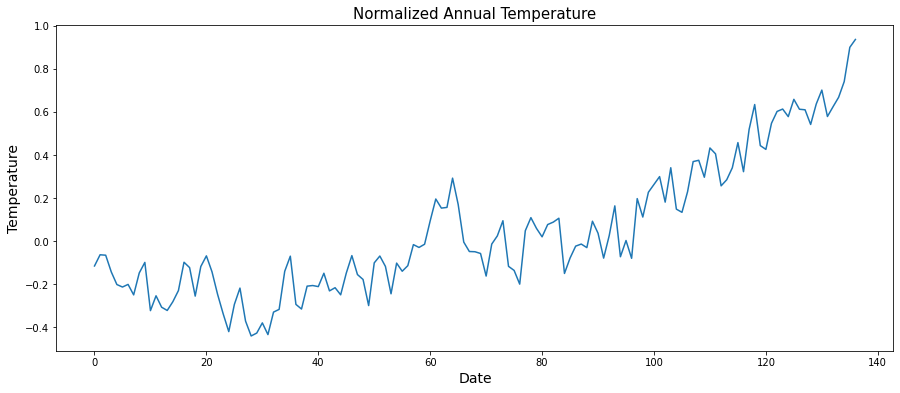

In [7]:
# Visualising the data

data.plot(x='Year',y='Mean',figsize = (15, 6), legend = None)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Temperature', fontsize = 14)
plt.title('Normalized Annual Temperature', fontsize = 15)
plt.show()

### Visualising Moving Averages of the Surface Temperatures:

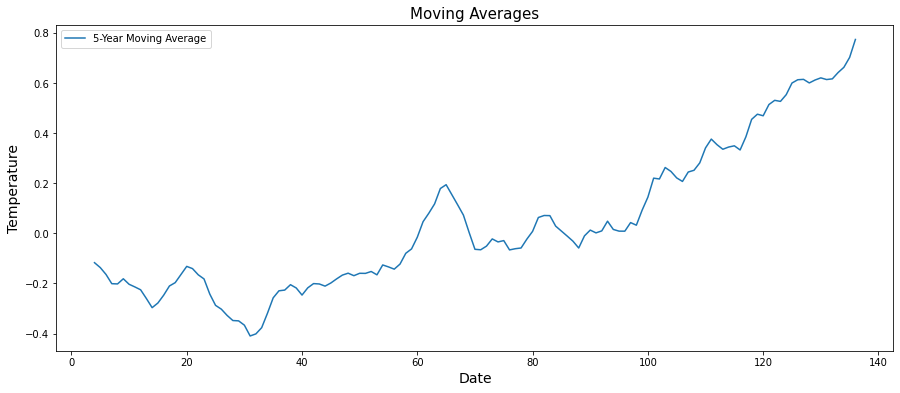

In [8]:
fiveyearly = data['Mean'].rolling(window = 5).mean()
fiveyearly[4:].plot(figsize = (15, 6), label = '5-Year Moving Average')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Temperature', fontsize = 14)
plt.title('Moving Averages', fontsize = 15)
plt.legend()
plt.show()

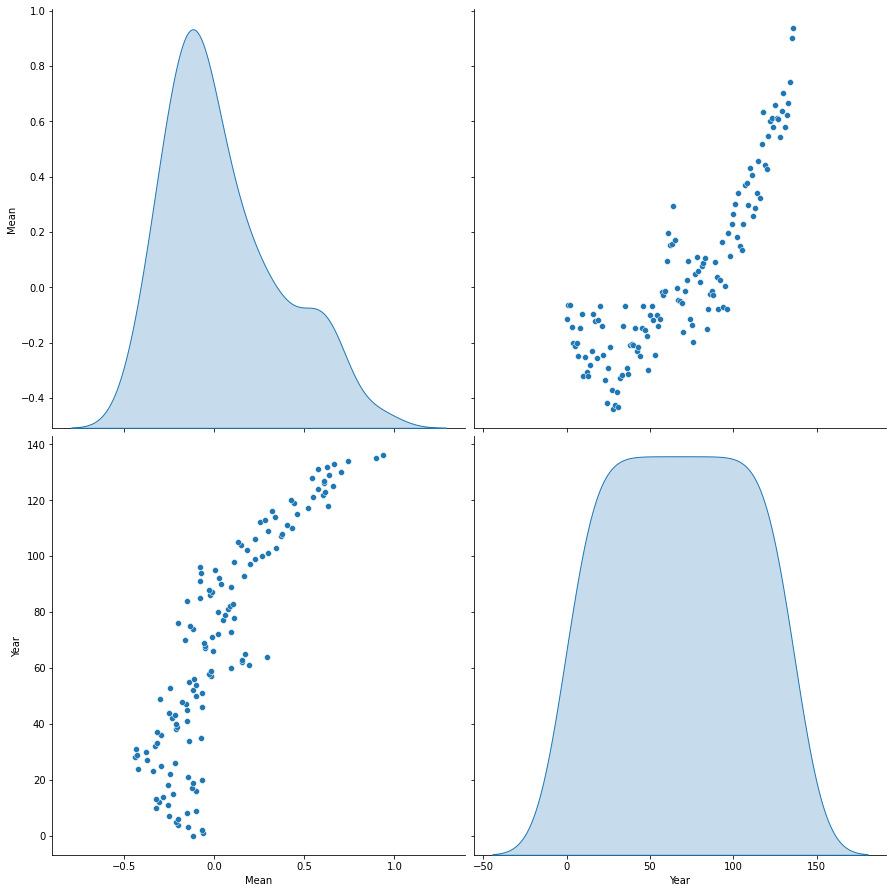

In [9]:
sns.pairplot(data[['Mean', 'Year']], diag_kind='kde', height=6.3)

## Linear Regression and DNNs:

### Creating Train and Test Splits:

In [10]:
train = data.sample(frac=0.8, random_state=0)
test = data.drop(train.index)

train_features = train.copy()
test_features = test.copy()

train_labels = train.pop('Mean')
test_labels = test.pop('Mean')

### Linear Regression model:

A single-variable linear regression to predict `'Mean'` from `'Year'`.

There are two steps in this single-variable linear regression model:

- Normalize the `'Year'` input features using the `tf.keras.layers.Normalization` preprocessing layer.
- Apply a linear transformation ($y = mx+b$) to produce 1 output using a linear layer (`tf.keras.layers.Dense`).

#### Normalization:

In [11]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [12]:
year = np.array(train_features['Year'])

year_normalizer = layers.Normalization(input_shape=[1,], axis=None)
year_normalizer.adapt(year)

#### Defining the model:

In [13]:
linear_model = tf.keras.Sequential([
    year_normalizer,
    layers.Dense(units=1)
])

linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


#### Compiling the Model:
We will use the Mean Squared Error (MSE) to calculate the loss and use the Adam optimizer.  
Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

In [14]:
linear_model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

#### Fitting the Model on the Data:

In [15]:
history = linear_model.fit(
    train_features['Year'],
    train_labels,
    epochs=40,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

#### Plotting the Training Loss:

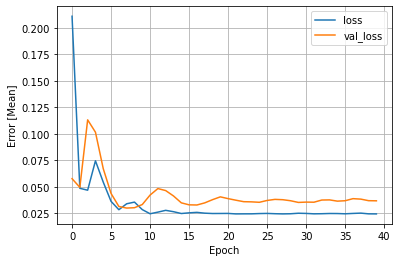

In [16]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [Mean]')
plt.legend()
plt.grid(True)

In [17]:
linear = linear_model.evaluate(
    test_features['Year'],
    test_labels, verbose=0
)

5/5 [==============================] - 0s 2ms/step


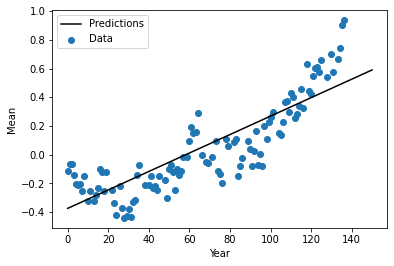

In [18]:
x = tf.linspace(0.0, 150, 151)
y = linear_model.predict(x)

plt.scatter(train_features['Year'], train_labels, label='Data')
plt.plot(x, y, color='k', label='Predictions')
plt.xlabel('Year')
plt.ylabel('Mean')
plt.legend()

### Deep Neural Networks:

This model will contain a few more layers than the linear model:

* The normalization layer, as before (`year_normalizer`).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

**Note: We will be reusing the previous normalization layer.**

#### Defining the model:

In [19]:
dnn_model = keras.Sequential([
    year_normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_1 (Dense)             (None, 64)                128       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


#### Compiling the model:

In [20]:
dnn_model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(0.001))

#### Fitting the model on the Data:

In [21]:
history = dnn_model.fit(
    train_features['Year'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=50)

#### Plotting the Training loss:

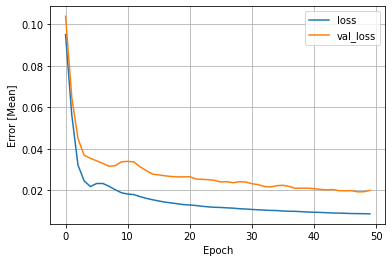

In [22]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [Mean]')
plt.legend()
plt.grid(True)

In [23]:
dnn = dnn_model.evaluate(
    test_features['Year'], test_labels,
    verbose=0
)

5/5 [==============================] - 0s 3ms/step


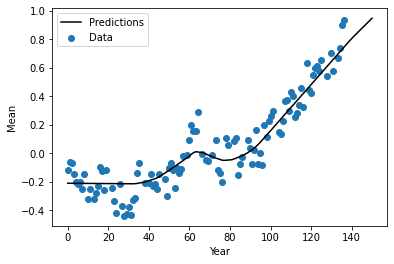

In [24]:
x = tf.linspace(0.0, 150, 151)
y = dnn_model.predict(x)

plt.scatter(train_features['Year'], train_labels, label='Data')
plt.plot(x, y, color='k', label='Predictions')
plt.xlabel('Year')
plt.ylabel('Mean')
plt.legend()

## Conclusion:

We can see the difference between different models for predicting data.

In [25]:
pd.DataFrame({'linear': linear, 'dnn': dnn}, index=['Mean squared error [Mean]']).T

,Mean squared error [Mean]
linear,0.018956
dnn,0.007183
